In [99]:
from math import sqrt
import numpy as np
from numpy import split
from numpy import array
from pandas import read_csv
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr

pd.options.display.float_format='{:,.20}'.format

In [100]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[5:140], data[140:175]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/5))
	test = array(split(test, len(test)/5))
	return train, test


In [101]:
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    
    print("Printing actual and predicted " , actual[0 , :] , predicted[0,:])
    
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = mse
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += np.abs((actual[row,col] - predicted[row,col]))
    score = (s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [102]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.15f' % s for s in scores])
	print('%s: [%.15f] %s' % (name, score, s_scores))
 
# prepare a list of ml models
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
	models['en'] = ElasticNet()
	models['huber'] = HuberRegressor()
	models['lars'] = Lars()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['ranscac'] = RANSACRegressor()
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	print('Defined %d models' % len(models))
	return models

In [103]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

In [104]:
# make a recursive multi-step forecast
def forecast(model, input_x, n_input):
	yhat_sequence = list()
	input_data = [x for x in input_x]
	for j in range(5):
		# prepare the input data
		X = array(input_data[-n_input:]).reshape(1, n_input)
		# make a one-step forecast
		yhat = model.predict(X)[0]
		# add to the result
		yhat_sequence.append(yhat)
		# add the prediction to the input
		input_data.append(yhat)
	return yhat_sequence

In [105]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 14] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series

In [106]:
# convert history into inputs and outputs
def to_supervised(history, n_input):
	# convert history to a univariate series
	data = to_series(history)
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(data)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		# ensure we have enough data for this instance
		if ix_end < len(data):
			X.append(data[ix_start:ix_end])
			y.append(data[ix_end])
		# move along one time step
		ix_start += 1
	return array(X), array(y)

In [107]:
# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
	# prepare data
	train_x, train_y = to_supervised(history, n_input)
	# make pipeline
	pipeline = make_pipeline(model)
	# fit the model
	pipeline.fit(train_x, train_y)
	# predict the week, recursively
	yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
	return yhat_sequence

In [108]:
# evaluate a single model
def evaluate_model(model, train, test, n_input):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = sklearn_predict(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 14], predictions)
	return score, scores

In [128]:
# load the new file
df = read_csv('1.csv')

df1 = pd.to_datetime(df['Epoch_Time_of_Clock'])
df['Epoch_Time_of_Clock']=df1
df.index = pd.to_datetime(df['Epoch_Time_of_Clock'],format='%Y-%m-%d %H:%M:%S')
#df.index = df['sqrt_A']

df1 = pd.concat([df['sqrt_A'] , df['e'],df['i0'],df['omega'],df['OMEGA'],df['Del_n'],df['M0']],axis=1)
df1.head()

df3 = pd.DataFrame()

for i in range(1, 6):
    df3["lag_{}".format(i)] = df1.e.shift(i)
    
dataset=df3
# split into train and test
train, test = split_dataset(dataset.values)
# prepare the models to evaluate
models = get_models()
n_input = 5
# evaluate each model
days = ['one', 'two', 'three', 'four', 'five']
for name, model in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(model, train, test, n_input)
    # summarize scores
    print("Score " , score)
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

Defined 10 models


IndexError: index 14 is out of bounds for axis 1 with size 5

In [129]:
#df1.loc['2017-11-01 14:00:00']
df1

,sqrt_A,e,i0,omega,OMEGA,Del_n,M0
Epoch_Time_of_Clock,,,,,,,
2017-11-01 14:00:00,"5,153.6701965299998847",0.0070940352743500013216,0.96871190895600001181,0.63272009923999994463,1.0093728597000000136,4.874845914039999901e-09,2.7556365782499998573
2017-11-01 16:00:00,"5,153.6691875500000606",0.0070945619372700004235,0.96871347574200006303,0.63273892260700004275,1.0093125596799998878,4.9169905266799998508e-09,-2.4773812940900001855
2017-11-01 18:00:00,"5,153.6698875399997632",0.0070945401676000014596,0.96871571254299992937,0.63268337999699997276,1.009252446909999934,4.874845914039999901e-09,-1.4271394581600000961
2017-11-01 20:00:00,"5,153.6703052499997284",0.0070946244522899996193,0.96871721203500005259,0.63265364472399998608,1.0091919157500000015,4.8752030717799997284e-09,-0.37692427951800011598
2017-11-01 22:00:00,"5,153.6732406600003742",0.0070961215533300002478,0.96871909334700001537,0.63270434800099994987,1.0091313319199999299,4.7530551266799999166e-09,0.67320921416299994711
2017-11-02 00:00:00,"5,153.672241209999811",0.0070962270256100003218,0.96872071864899989002,0.63261883897699999757,1.009070401390000038,4.7416260791900005539e-09,1.7234776298500000813
2017-11-02 12:00:00,"5,153.6721286800002417",0.0070987020153599998673,0.96873138917400003489,0.63246247790400000888,1.0087084959299998932,4.9194906308200003243e-09,1.7415583478799998574
2017-11-02 14:00:00,"5,153.6693687400002091",0.0070995468413500000676,0.96873510791099992634,0.63229294617900000386,1.0086484519299998563,4.8519878190499997346e-09,2.7919136257899999087
2017-11-02 16:00:00,"5,153.6686363199996777",0.0070999214658499995578,0.96873808348699996795,0.63230983703100007709,1.0085885922399999703,4.8905608543500001287e-09,-2.4411020214500003256


In [125]:
df

,Unnamed: 0,Unnamed: 0.1,PRN,Epoch_Time_of_Clock,SV_Clock_Bias,SV_Clock_Drift,SV_Clock_Drift_Rate,IODE,Crs,Del_n,...,I_dot,Codes,GPS_week,L2_P_Data_flag,SV_accuracy,SV_health,Tgd,IODC,T_Tx,Fit_Interval
0,0,80,1,2017-11-01 14:00:00,-7.6745636761199992847e-06,-2.3874235921499998426e-12,0,30,20.71875,4.874845914039999901e-09,...,2.2393789934099997288e-10,1,1973,0,0,0,5.5879354476899999498e-09,30,302466,0
1,1,88,1,2017-11-01 16:00:00,-7.6913274824599997802e-06,-2.3874235921499998426e-12,0,31,16.8125,4.9169905266799998508e-09,...,3.0465554726900001994e-10,1,1973,0,0,0,5.5879354476899999498e-09,31,309606,0
2,2,101,1,2017-11-01 18:00:00,-7.7085569500899998858e-06,-2.3874235921499998426e-12,0,32,13.84375,4.874845914039999901e-09,...,2.971552348510000147e-10,1,1973,0,0,0,5.5879354476899999498e-09,32,316806,0
3,3,109,1,2017-11-01 20:00:00,-7.7253207564399987582e-06,-2.3874235921499998426e-12,0,33,12.28125,4.8752030717799997284e-09,...,2.5822504182400002217e-10,1,1973,0,0,0,5.5879354476899999498e-09,33,324006,0
4,4,124,1,2017-11-01 22:00:00,-7.7420845627800026419e-06,-2.3874235921499998426e-12,0,34,23.03125,4.7530551266799999166e-09,...,2.0000833115000001666e-10,1,1973,0,0,0,5.5879354476899999498e-09,34,331206,0
5,5,135,1,2017-11-02 00:00:00,-7.7593140304100010533e-06,-2.3874235921499998426e-12,0,69,29.0,4.7416260791900005539e-09,...,2.5465346448199998183e-10,1,1973,0,1,0,5.5879354476899999498e-09,69,338406,0
6,6,218,1,2017-11-02 12:00:00,-7.8575685620300011076e-06,-2.3874235921499998426e-12,0,73,40.03125,4.9194906308200003243e-09,...,3.4822879084099999123e-10,1,1973,0,0,0,5.5879354476899999498e-09,73,387756,0
7,7,221,1,2017-11-02 14:00:00,-7.874332368369999909e-06,-2.3874235921499998426e-12,0,74,46.5625,4.8519878190499997346e-09,...,4.1644591807300001016e-10,1,1973,0,0,0,5.5879354476899999498e-09,74,388806,0
8,8,233,1,2017-11-02 16:00:00,-7.8910961747200004756e-06,-2.3874235921499998426e-12,0,75,43.84375,4.8905608543500001287e-09,...,5.128785063059999523e-10,1,1973,0,0,0,5.5879354476899999498e-09,75,396006,0
9,9,244,1,2017-11-02 18:00:00,-7.9078599810600009711e-06,-2.3874235921499998426e-12,0,76,41.75,4.8662741284199993983e-09,...,4.9680640826699995171e-10,1,1973,0,0,0,5.5879354476899999498e-09,76,403206,0


In [112]:
df = pd.read_csv('1.csv')

In [113]:
df.columns
#df['sqrt_A']=np.power(df['sqrt_A'],2)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'PRN', 'Epoch_Time_of_Clock',
       'SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
       'Del_n', 'M0', 'Cuc', 'e', 'Cus', 'sqrt_A', 'Toe', 'Cic', 'OMEGA',
       'Cis', 'i0', 'Crc', 'omega', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval'],
      dtype='object')

In [114]:
train, test = split_dataset(df.values)

In [118]:
train.shape
test

array([[[140, 3553, 1, ..., 104, 482406, 0],
        [141, 3566, 1, ..., 155, 489606, 0],
        [142, 3577, 1, ..., 25, 496806, 0],
        [143, 3589, 1, ..., 26, 504006, 0],
        [144, 3675, 1, ..., 32, 553806, 0]],

       [[145, 3678, 1, ..., 33, 554406, 0],
        [146, 3692, 1, ..., 65, 561606, 0],
        [147, 3705, 1, ..., 90, 568806, 0],
        [148, 3720, 1, ..., 91, 576006, 0],
        [149, 3734, 1, ..., 35, 583206, 0]],

       [[150, 3746, 1, ..., 66, 590406, 0],
        [151, 3826, 1, ..., 139, 35166, 0],
        [152, 3835, 1, ..., 140, 36006, 0],
        [153, 3848, 1, ..., 141, 43206, 0],
        [154, 3860, 1, ..., 142, 50406, 0]],

       ...,

       [[160, 3991, 1, ..., 77, 129606, 0],
        [161, 4005, 1, ..., 78, 136806, 0],
        [162, 4019, 1, ..., 92, 144006, 0],
        [163, 4030, 1, ..., 46, 151206, 0],
        [164, 4044, 1, ..., 69, 158406, 0]],

       [[165, 4128, 1, ..., 85, 208836, 0],
        [166, 4135, 1, ..., 86, 216006, 0],
        [

In [116]:
train

array([[[5, 135, 1, ..., 69, 338406, 0],
        [6, 218, 1, ..., 73, 387756, 0],
        [7, 221, 1, ..., 74, 388806, 0],
        [8, 233, 1, ..., 75, 396006, 0],
        [9, 244, 1, ..., 76, 403206, 0]],

       [[10, 261, 1, ..., 77, 410406, 0],
        [11, 278, 1, ..., 78, 417606, 0],
        [12, 369, 1, ..., 43, 474846, 0],
        [13, 378, 1, ..., 44, 475206, 0],
        [14, 388, 1, ..., 81, 482406, 0]],

       [[15, 402, 1, ..., 82, 489606, 0],
        [16, 413, 1, ..., 84, 496806, 0],
        [17, 426, 1, ..., 101, 504006, 0],
        [18, 522, 1, ..., 87, 561006, 0],
        [19, 525, 1, ..., 88, 561606, 0]],

       ...,

       [[125, 3146, 1, ..., 54, 244806, 0],
        [126, 3235, 1, ..., 61, 297246, 0],
        [127, 3243, 1, ..., 73, 302406, 0],
        [128, 3260, 1, ..., 74, 309636, 0],
        [129, 3269, 1, ..., 153, 316806, 0]],

       [[130, 3281, 1, ..., 154, 324006, 0],
        [131, 3296, 1, ..., 3, 331206, 0],
        [132, 3384, 1, ..., 18, 381636, 0],


In [57]:
models = get_models()

Defined 10 models


In [58]:
models['lr']

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [122]:
hist = [x for x in train]   #copying train to hist
hist

(5, 33)

In [60]:
len(hist)

27

In [61]:
hist[0].shape

(5, 33)

In [62]:
train_x , train_y = to_supervised(hist , 5)

In [63]:
train_x
#np.power(train_x, 2)

array([[5153.67224121, 5153.67212868, 5153.66936874, 5153.66863632,
        5153.66860771],
       [5153.67212868, 5153.66936874, 5153.66863632, 5153.66860771,
        5153.66959381],
       [5153.66936874, 5153.66863632, 5153.66860771, 5153.66959381,
        5153.67206573],
       [5153.66863632, 5153.66860771, 5153.66959381, 5153.67206573,
        5153.6734581],
       [5153.66860771, 5153.66959381, 5153.67206573, 5153.6734581,
        5153.67034912],
       [5153.66959381, 5153.67206573, 5153.6734581, 5153.67034912,
        5153.66972733],
       [5153.67206573, 5153.6734581, 5153.67034912, 5153.66972733,
        5153.66918182],
       [5153.6734581, 5153.67034912, 5153.66972733, 5153.66918182,
        5153.67046547],
       [5153.67034912, 5153.66972733, 5153.66918182, 5153.67046547,
        5153.67217255],
       [5153.66972733, 5153.66918182, 5153.67046547, 5153.67217255,
        5153.67560768],
       [5153.66918182, 5153.67046547, 5153.67217255, 5153.67560768,
        5153.6730

In [64]:
train_y[0]

5153.66959381

In [65]:
pipeline = make_pipeline(models['lr'])

In [66]:
pipeline.fit(train_x,train_y)

/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [123]:
input_x = train_x[-1, : ]
input_x

array([5153.68056679, 5153.68127251, 5153.68191147, 5153.68182182,
       5153.68195343], dtype=object)

In [124]:
input_data = [x for x in input_x]
#np.power(input_data,2)
input_data

[5153.68056679, 5153.68127251, 5153.68191147, 5153.68182182, 5153.68195343]

In [69]:
yhat_sequence = []
for j in range(5):
    # prepare the input data
    X = array(input_data[-n_input:]).reshape(1, n_input)
    print(X)
    # make a one-step forecast
    yhat = model.predict(X)[0]
    print("**")
    print(yhat)
    # add to the result
    yhat_sequence.append(yhat)
    # add the prediction to the input
    input_data.append(yhat)

[[5153.68056679 5153.68127251 5153.68191147 5153.68182182 5153.68195343]]


NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [70]:
test.shape

(7, 5, 33)

In [71]:
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence = sklearn_predict(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
predictions = array(predictions)

/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionW

In [72]:
#test
predictions

array([[5153.68164822, 5153.68177317, 5153.68161354, 5153.68172107,
        5153.68155912],
       [5153.68070318, 5153.68011822, 5153.68079459, 5153.68027835,
        5153.68064454],
       [5153.67928056, 5153.67901454, 5153.67922136, 5153.67898044,
        5153.67923425],
       [5153.6772644 , 5153.67682071, 5153.67750389, 5153.67695566,
        5153.67747976],
       [5153.67560733, 5153.67680053, 5153.67658464, 5153.67667151,
        5153.67640365],
       [5153.67612098, 5153.67685544, 5153.67587238, 5153.67701038,
        5153.67635401],
       [5153.67337766, 5153.67324566, 5153.6733438 , 5153.67350885,
        5153.67376678]])

In [73]:
score, scores = evaluate_forecasts(test[:, :, 14], predictions)

Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68164822 5153.68177317 5153.68161354 5153.68172107 5153.68155912]


In [ ]:
score

In [74]:
scores

[0.00141711688450284,
 0.002351956058581501,
 0.0017743962954617537,
 0.002110141709506154,
 0.0015293732644100341]

In [75]:
test[:, :, 14]

array([[5153.68014526, 5153.68021965, 5153.68157387, 5153.68034363,
        5153.67912865],
       [5153.68011665, 5153.67901802, 5153.67896843, 5153.67871475,
        5153.68069649],
       [5153.67853355, 5153.67726898, 5153.67762184, 5153.67633247,
        5153.67708969],
       [5153.67686081, 5153.67934036, 5153.67672157, 5153.67558479,
        5153.67490196],
       [5153.67365456, 5153.67473793, 5153.67487907, 5153.67761421,
        5153.67525291],
       [5153.67251396, 5153.67150497, 5153.67233276, 5153.67309189,
        5153.67578506],
       [5153.6744976, 5153.67111397, 5153.67041588, 5153.67055893,
        5153.67198563]], dtype=object)

Defined 10 models
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68164822 5153.68177317 5153.68161354 5153.68172107 5153.68155912]
Score  0.0018365968424924567
lr: [0.001836596842492] 0.001417116884503, 0.002351956058582, 0.001774396295462, 0.002110141709506, 0.001529373264410
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.6773082 5153.6773082 5153.6773082 5153.6773082 5153.6773082]
Score  0.0027679352338444525
lasso: [0.002767935233844] 0.002663257502198, 0.003047852721595, 0.003027018930620, 0.002648725002603, 0.002452822012206
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68149956 5153.68159608 5153.68147372 5153.68150132 5153.68136074]
Score  0.0018658639103055715
ridge: [0.001865863910306] 0.001525144368316, 0.002265395192288, 0.001835943403291, 0.002081581257828, 0.001621255329805
Printing actual

/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionW

Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68186618 5153.68212961 5153.68215036 5153.6823407  5153.68233579]
Score  0.0019390103209454017
huber: [0.001939010320945] 0.001489656016150, 0.002401427368958, 0.001888314723146, 0.002234868651612, 0.001680784844861
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68164822 5153.68177317 5153.68161354 5153.68172107 5153.68155912]
Score  0.0018365968424924567
lars: [0.001836596842492] 0.001417116884503, 0.002351956058582, 0.001774396295462, 0.002110141709506, 0.001529373264410
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.6773082 5153.6773082 5153.6773082 5153.6773082 5153.6773082]
Score  0.0027679352338444525
llars: [0.002767935233844] 0.002663257502198, 0.003047852721595, 0.003027018930620, 0.002648725002603, 0.002452822012206
Printing actual and predicted  

/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/

Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5.15529840e+03 1.05899249e+04 1.82864753e+07 6.14775197e+10
 2.06740238e+14]
Score  101701541349193.42
sgd: [101701541349193.421875000000000] 4.876345185565826, 15273.122768715709753, 48625572.152192533016205, 156587920023.869903564453125, 508351070185093.062500000000000


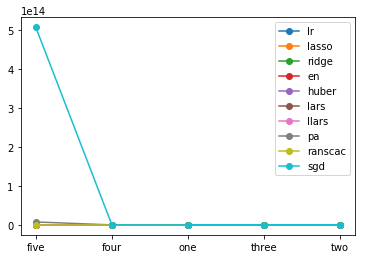

In [76]:
dataset = pd.read_csv('1.csv')
# split into train and test
train, test = split_dataset(dataset.values)
# prepare the models to evaluate
models = get_models()
n_input = 5
# evaluate each model
days = ['one', 'two', 'three', 'four', 'five']
for name, model in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(model, train, test, n_input)
    # summarize scores
    print("Score " , score)
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()